In [1]:
import pandas as pd
import sys
sys.path.insert(1,'E:\DUY\DS\deeplearning\CustomTools')
import ultility_tools as utt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [2]:
data = pd.read_csv('DATA/CreditCardDefault/credit_card_default.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# create the feature set
X = data.drop('default payment next month',axis=1)

# create the response set
y = data['default payment next month']

In [4]:
# get the null accuracy (baseline)
print(y.value_counts(normalize=True))


0    0.7788
1    0.2212
Name: default payment next month, dtype: float64


# Creating a Baseline ML Pipeline for Classification problem

In [5]:
models ={"model_name": ["Logistic Regression",
                        "KNN",
                        "Decision Tree",
                        "Random Forest"],
         "model_command": [LogisticRegression(),
                           Pipeline([('scaler',StandardScaler()),('classifier',KNeighborsClassifier())]),
                           DecisionTreeClassifier(),
                           RandomForestClassifier()],
         "model_params": [{'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']},
                          {'classifier__n_neighbors': [1, 3, 5, 7]},
                          {'max_depth':[None, 1, 3, 5, 7]},
                          {'n_estimators': [10, 50, 100], 'max_depth': [None, 1, 3, 5, 7]}]
         }

best_grid, df_models_results = utt.get_all_best_models(models, X, y)
df_models_results


,model_name,best_score,best_params,fit_time,score_time
0,Logistic Regression,0.778833,"{'C': 100.0, 'penalty': 'l2'}",0.152245,0.000822
1,KNN,0.799333,{'classifier__n_neighbors': 7},0.149401,3.130825
2,Decision Tree,0.820633,{'max_depth': 3},0.146089,0.001396
3,Random Forest,0.818467,"{'max_depth': 7, 'n_estimators': 50}",0.980155,0.025320


# Feature Selection: using PolynomialFeatures & Decision Tree

In [6]:
poly_tree = Pipeline([("poly",PolynomialFeatures()),
                          ("classifier",DecisionTreeClassifier())])
poly_tree_paras = {'poly__degree':[2],
                   'classifier__max_depth': [None, 1, 3, 5, 7]}

grid1 = utt.get_best_for_model(poly_tree, poly_tree_paras, X, y)


************************************************
Best Accuracy: 0.8211333333333334
Best Parameters: {'classifier__max_depth': 3, 'poly__degree': 2}
Average Time to Fit: 2.524 (s)
Average Time to Score: 0.018 (s)
************************************************


# Feature Selection: using Correlation Matrix values & Decision Tree

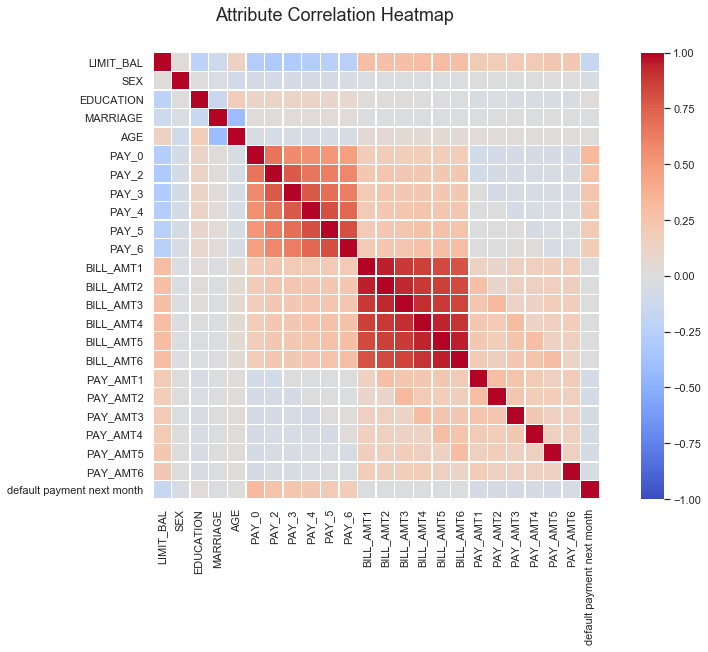

************************************************
Best Accuracy: 0.8207333333333333
Best Parameters: {'classifier__max_depth': 3, 'corr_chooser__threshold': 0.2}
Average Time to Fit: 0.081 (s)
Average Time to Score: 0.002 (s)
************************************************


In [7]:
# get correlation matrix
corr = utt.get_corr(data,annot=False)

# pipeline
ccc = utt.CustomCorrelationChooser(response=y)
d_tree = DecisionTreeClassifier()
corr_tree = Pipeline([("corr_chooser",ccc),
                      ("classifier",d_tree)])
corr_tree_params = {"corr_chooser__threshold":[0,0.1,0.2,0.3],
                    "classifier__max_depth":[None, 1, 3, 5, 7]}
grid2 = utt.get_best_for_model(corr_tree , corr_tree_params, X, y)

In [20]:
# OLD WAY (MANUAL)
ccc = utt.CustomCorrelationChooser(response=y,threshold=0.2)
ccc.fit(X)
print(ccc.cols_to_keep)


Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')


# Feature Selection: using KBest and f_classif (ANOVA p-values test) & Decision Tree

In [9]:
kbest = SelectKBest(f_classif)
d_tree = DecisionTreeClassifier()
kbest_tree = Pipeline([("k_best",kbest),("classifier",d_tree)])
kbest_tree_params = {"k_best__k":[1,2,3,4,5,6,7,8,9,10],
                     "classifier__max_depth":[None,1,3,5,7]}
grid3 = utt.get_best_for_model(kbest_tree , kbest_tree_params, X, y)

************************************************
Best Accuracy: 0.8213333333333332
Best Parameters: {'classifier__max_depth': 3, 'k_best__k': 5}
Average Time to Fit: 0.025 (s)
Average Time to Score: 0.001 (s)
************************************************


In [10]:
kbest = SelectKBest(f_classif,k=5)
kbest.fit_transform(X,y)
p_values = pd.DataFrame({'column': X.columns, 'p_value': kbest.pvalues_}).sort_values('p_value')
p_values.head()

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279


In [11]:
# a better way
kbest_tree.set_params(**grid3.best_params_)
kbest_tree.steps[0][1].fit(X,y)
X.columns[kbest_tree.steps[0][1].get_support()]

Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')

# Feature Selection: using SelectFromModel (Decision Tree) & Decision Tree

In [12]:
select_model = SelectFromModel(DecisionTreeClassifier())
d_tree = DecisionTreeClassifier()
select_model_tree = Pipeline([("select_model",select_model),("classifier",d_tree)])
select_model_tree_params = {"select_model__threshold": [.01, .05, .1, .2, .25, .3, .4, .5, .6, "mean", "median", "2.*mean"],
                            "select_model__estimator__max_depth": [None, 1, 3, 5, 7],
                            "classifier__max_depth":[None,1,3,5,7]}
grid4 = utt.get_best_for_model(select_model_tree , select_model_tree_params, X, y)

************************************************
Best Accuracy: 0.8206333333333333
Best Parameters: {'classifier__max_depth': 3, 'select_model__estimator__max_depth': 1, 'select_model__threshold': 'median'}
Average Time to Fit: 0.164 (s)
Average Time to Score: 0.001 (s)
************************************************


In [13]:
select_model_tree.set_params(**grid4.best_params_)
select_model_tree.steps[0][1].fit(X,y)
X.columns[select_model_tree.steps[0][1].get_support()]

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

# Feature Selection: using SelectFromModel (LogisticRegression) & Decision Tree

In [14]:
select_model_LR = SelectFromModel(LogisticRegression())
d_tree = DecisionTreeClassifier()
select_model_LR_tree = Pipeline([("select_model",select_model_LR),("classifier",d_tree)])
select_model_LR_tree_params = {"select_model__threshold": [.01, .05, .1, .2, "mean", "median", "2.*mean"],
                            "select_model__estimator__penalty": ['l1','l2'],
                            "classifier__max_depth":[None,1,3,5,7]}
grid5 = utt.get_best_for_model(select_model_LR_tree , select_model_LR_tree_params, X, y)

************************************************
Best Accuracy: 0.8207000000000001
Best Parameters: {'classifier__max_depth': 3, 'select_model__estimator__penalty': 'l2', 'select_model__threshold': 'median'}
Average Time to Fit: 0.086 (s)
Average Time to Score: 0.0 (s)
************************************************


In [15]:
select_model_LR_tree.set_params(**grid5.best_params_)
select_model_LR_tree.steps[0][1].fit(X,y)
X.columns[select_model_LR_tree.steps[0][1].get_support()]

Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2'],
      dtype='object')

In [16]:
#OR
lr = LogisticRegression(penalty='l2')
lr.fit(X,y)
coeff_values = pd.DataFrame({'column': X.columns, 'coeff_value': lr.coef_.reshape(-1,)}).sort_values('coeff_value',ascending=False)
coeff_values


,column,coeff_value
5,PAY_0,5.072907e-05
6,PAY_2,3.938047e-05
7,PAY_3,3.475645e-05
8,PAY_4,3.275442e-05
9,PAY_5,3.078160e-05
10,PAY_6,2.880201e-05
16,BILL_AMT6,3.859960e-06
14,BILL_AMT4,3.722612e-06
13,BILL_AMT3,2.436832e-06
15,BILL_AMT5,2.417408e-06


# Feature Selection: using SelectFromModel (Support Vector Classification-SVC) & Decision Tree

In [17]:
select_model_LSVC = SelectFromModel(LinearSVC())
d_tree = DecisionTreeClassifier()
select_model_LSVC_tree = Pipeline([("select_model",select_model_LSVC),("classifier",d_tree)])
select_model_LSVC_tree_params = {"select_model__threshold": [.01, .05, .1, .2, "mean", "median", "2.*mean"],
                                 "select_model__estimator__penalty": ['l1','l2'],
                                 "select_model__estimator__loss": ['squared_hinge', 'hinge'],
                                 "select_model__estimator__dual": [True, False],
                                 "classifier__max_depth":[None,1,3,5,7]}
grid6 = utt.get_best_for_model(select_model_LSVC_tree , select_model_LSVC_tree_params, X, y)

************************************************
Best Accuracy: 0.8212999999999999
Best Parameters: {'classifier__max_depth': 5, 'select_model__estimator__dual': True, 'select_model__estimator__loss': 'hinge', 'select_model__estimator__penalty': 'l2', 'select_model__threshold': 'median'}
Average Time to Fit: 0.765 (s)
Average Time to Score: 0.0 (s)
************************************************


In [18]:
select_model_LSVC_tree.set_params(**grid6.best_params_)
select_model_LSVC_tree.steps[0][1].fit(X,y)
X.columns[select_model_LSVC_tree.steps[0][1].get_support()]



Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT2', 'PAY_AMT5'],
      dtype='object')

In [19]:
#OR
# lsvc = LinearSVC(penalty='l1', loss='squared_hinge',dual=False)
lsvc = grid6.best_estimator_.steps[0][1].estimator_
lsvc.fit(X,y)
coeff_values_lsvc = pd.DataFrame({'column': X.columns, 'coeff_value': lsvc.coef_.reshape(-1,)}).sort_values('coeff_value',ascending=False)
coeff_values_lsvc.head(6)


,column,coeff_value
8,PAY_4,0.001991
10,PAY_6,0.001913
9,PAY_5,0.001891
7,PAY_3,0.001728
5,PAY_0,0.001600
6,PAY_2,0.001592
